In [1]:
from keras.applications import ResNet50
from keras.preprocessing import image
import numpy as np
from keras.applications import VGG16
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import os
from keras.applications.resnet50 import *
import numpy as np
import time
from keras.applications import vgg16
from keras import backend as K
from keras.applications import vgg16
from matplotlib import pyplot as plt
from collections import OrderedDict

Using TensorFlow backend.


In [2]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [3]:
vgg16 = vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [4]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [5]:
layer_dict = OrderedDict()
for layer in vgg16.layers[1:]:
    layer_dict[layer.name] = layer


In [6]:
IMAGENET_FOLDER = 'Retinal/train/AMD' 

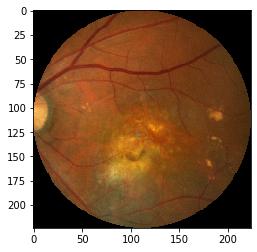

In [7]:
img_path = os.path.join(IMAGENET_FOLDER, 'A0020.jpg')
img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)

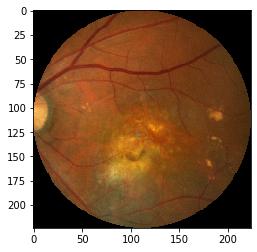

In [24]:
input_img_data = image.img_to_array(img)
input_img_data /= 255
plt.imshow(input_img_data)

In [9]:
input_img_data = np.expand_dims(input_img_data, axis=0)
print('Input image shape:', input_img_data.shape)

Input image shape: (1, 224, 224, 3)


In [10]:
def get_activations(model, layer, input_img_data):
    activations_f = K.function([model.layers[0].input, K.learning_phase()], [layer.output,])
    activations = activations_f((input_img_data, False))
    return activations


In [11]:
layer_name = 'block1_conv2'
layer = layer_dict[layer_name]
activations = get_activations(vgg16, layer, input_img_data)


In [12]:
print(len(activations))
activation = activations[0]
activation.shape
layer.filters

1


64

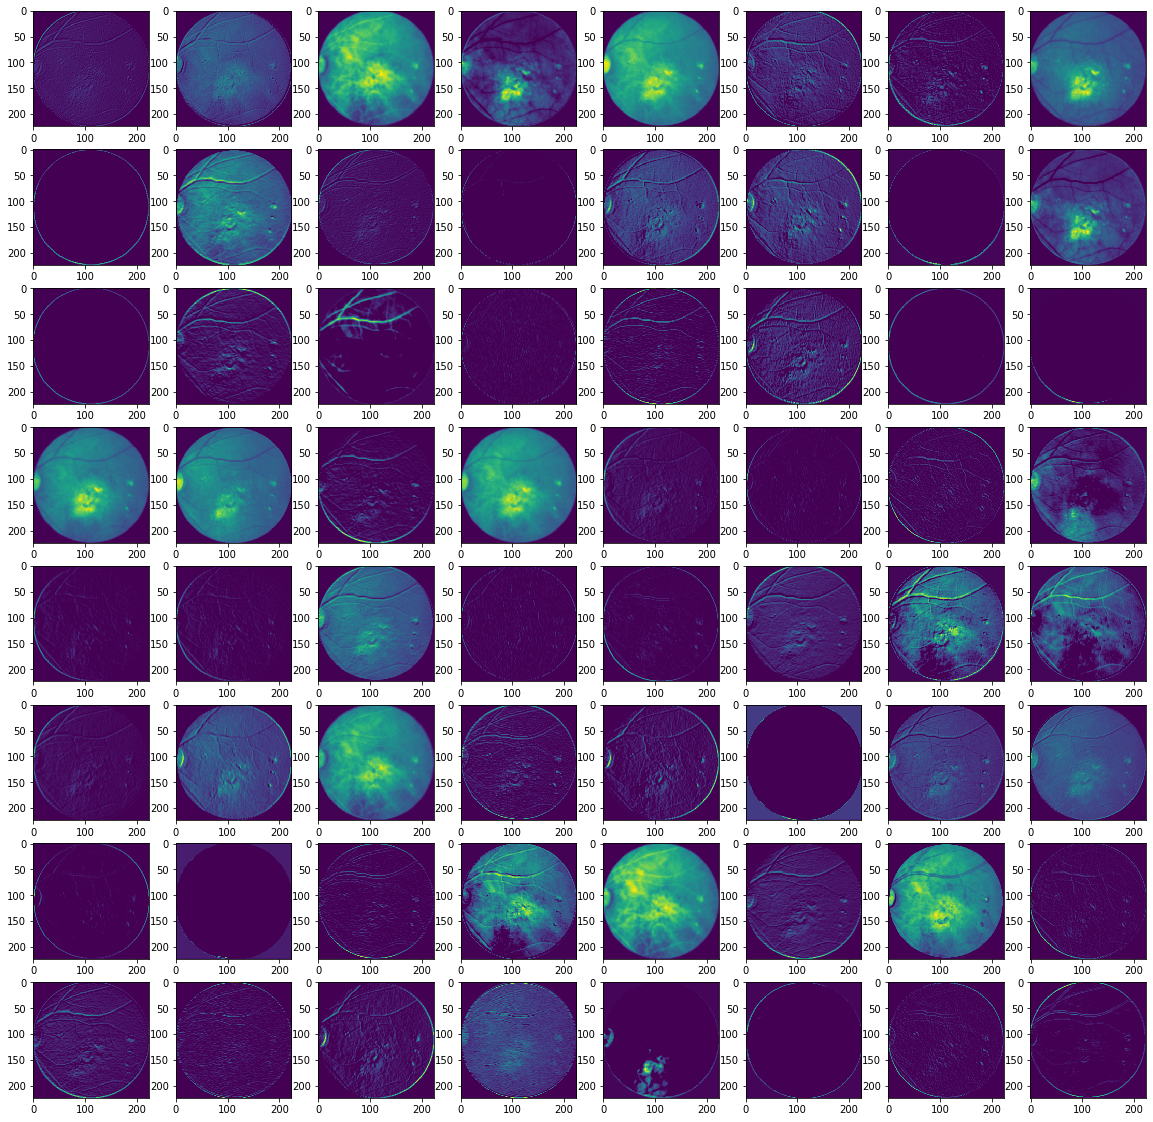

In [13]:
activated_img = activation[0]
n = 8
fig = plt.figure(figsize=(20, 20))
for i in range(n):
    for j in range(n):
        idx = (n*i)+j
        ax = fig.add_subplot(n, n, idx+1)
        ax.imshow(activated_img[:,:,idx])

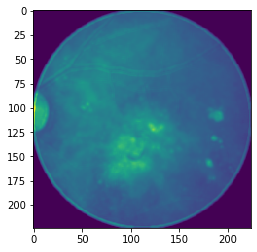

In [14]:
conv_img_mean = np.mean(activated_img, axis=2)
conv_img_mean.shape
plt.imshow(conv_img_mean)

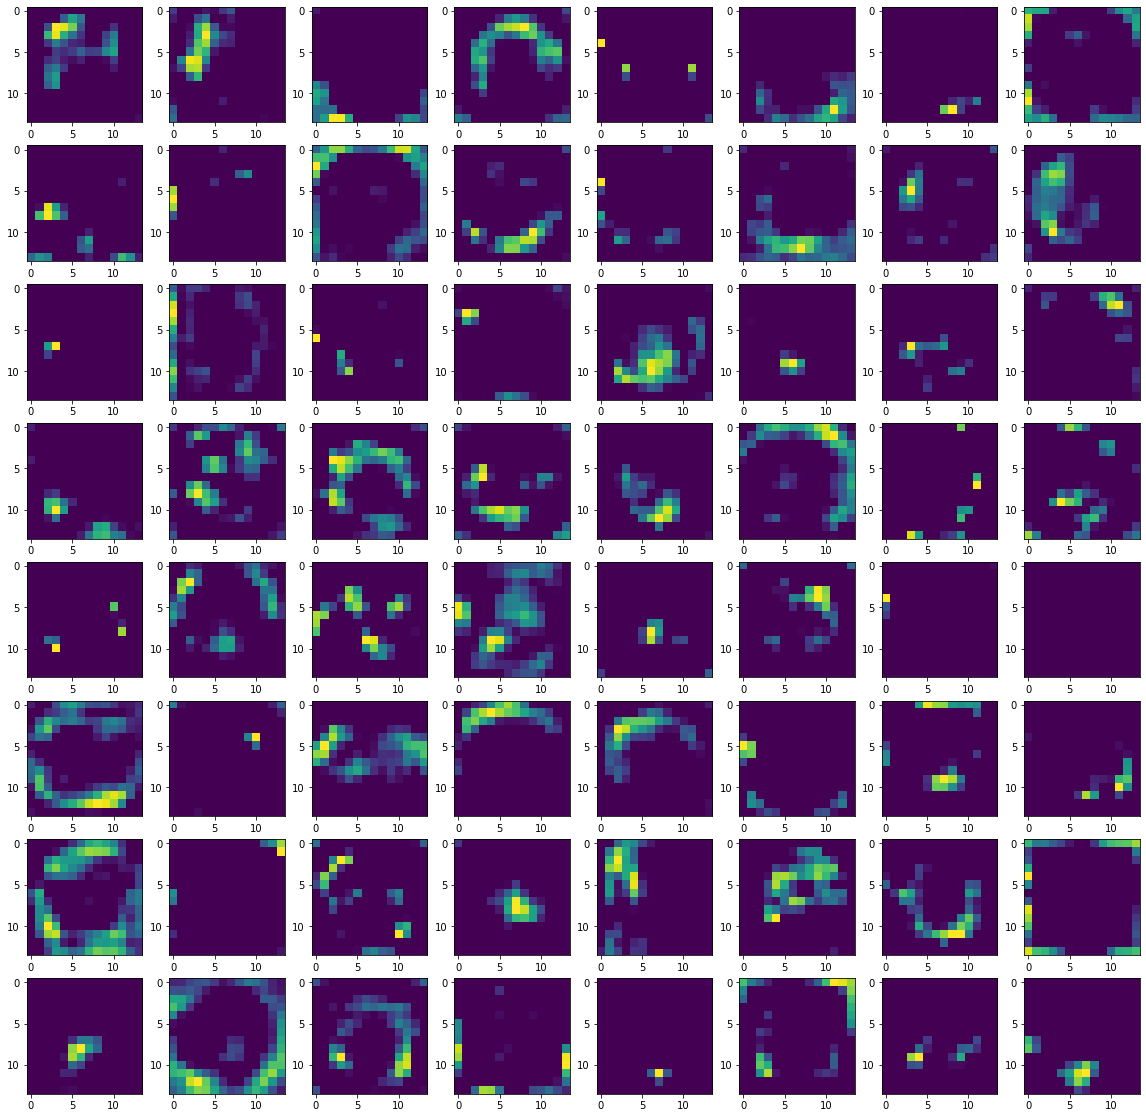

In [15]:
layer_name = 'block5_conv2'
layer = layer_dict[layer_name]
activations = get_activations(vgg16, layer, input_img_data)
activated_img = activations[0][0]  # [0][0] -> first (and only) activation, first (and only) sample in batch
n = 8
fig = plt.figure(figsize=(20, 20))
for i in range(n):
    for j in range(n):
        idx = (n*i)+j
        ax = fig.add_subplot(n, n, idx+1)
        ax.imshow(activated_img[:,:,idx])


In [20]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [25]:
img_width = 224
img_height = 224
def collect_filters(input_tensor, output_tensor, filters):
    kept_filters = []
    start_time = time.time()
    for filter_index in range(0, filters):
        if filter_index % 10 == 0:
            print('\t Processing filter {}'.format(filter_index))
        if K.image_data_format() == 'channels_first':
            loss = K.mean(output_tensor[:, filter_index, :, :])
        else:
            loss = K.mean(output_tensor[:, :, :, filter_index])
        grads = K.gradients(loss, input_tensor)[0]
        grads = grads / (K.sqrt(K.mean(K.square(grads))) + 1e-5)
        iterate = K.function([input_tensor], [loss, grads])
        step = 1.        
        if K.image_data_format() == 'channels_first':
            img_data = np.random.random((1, 3, img_width, img_height))
        else:
            img_data = np.random.random((1, img_width, img_height, 3))        
        img_data =img_data  #(img_data - 0.5) * 20 + 128
        for i in range(20):
            loss_value, grads_value = iterate([img_data])
            img_data += grads_value * step
            if loss_value <= 0.:
                break
        if loss_value > 0:
            img_deproc = deprocess_image(img_data[0])
            kept_filters.append((img_deproc, loss_value))            
    end_time = time.time()
    print('\t Time required to process {} filters: {}'.format(filters, (end_time - start_time)))            
    return kept_filters

In [26]:
input_t = vgg16.input
def generate_stiched_filters(layer, nb_filters):
    layer_name = layer.name
    print('Processing {} Layer'.format(layer_name))    
    layer_output = layer.output
    kept_filters = collect_filters(input_t, layer_output, nb_filters)    
    print('Filter collection: completed!')
    limit = min(nb_filters, len(kept_filters))
    n = np.floor(np.sqrt(limit)).astype(np.int)
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:n * n]    
    margin = 5
    width = n * img_width + (n - 1) * margin
    height = n * img_height + (n - 1) * margin
    stitched_filters = np.zeros((width, height, 3))
    for i in range(n):
        for j in range(n):
            img, loss = kept_filters[i * n + j]
            stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                             (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img
    return stitched_filters

Processing block1_conv2 Layer
	 Processing filter 0
	 Processing filter 10
	 Processing filter 20
	 Processing filter 30
	 Processing filter 40
	 Processing filter 50
	 Processing filter 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


	 Time required to process 64 filters: 81.12699031829834
Filter collection: completed!


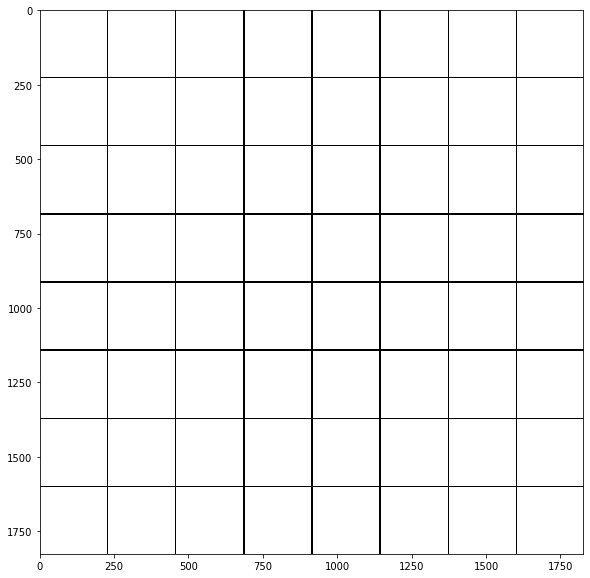

In [27]:
layer = layer_dict['block1_conv2']  
stitched_filters = generate_stiched_filters(layer, layer.filters)
plt.figure(figsize=(10,10))
plt.imshow(stitched_filters)

Processing block5_conv1 Layer
	 Processing filter 0
	 Processing filter 10
	 Processing filter 20
	 Processing filter 30
	 Processing filter 40
	 Processing filter 50
	 Processing filter 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


	 Time required to process 64 filters: 301.84766936302185
Filter collection: completed!


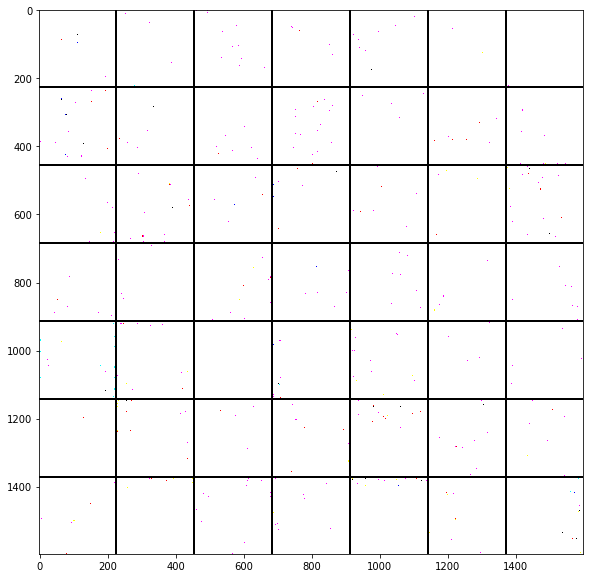

In [36]:
layer = layer_dict['block5_conv1'] 
stitched_filters = generate_stiched_filters(layer, 64)
plt.figure(figsize=(10,10))
plt.imshow(stitched_filters)